# Introduction

_Describe the problem the software solves and why it's important to solve that problem._

* Our software package computes gradients by leveraging the technique of automatic differentiation. Before we can understand automatic differentiation, we must first describe and motivate the importance of differentiation itself. Finding the derivative of a function measures the sensitivity to change of a function value with respect to a change in its input argument. Derivatives are not only essential in calculus applications like numerically solving differential equations and optimizing and solving linear systems, but are useful in many real world, scientific settings. For example, differentiation is essential in analyzing the profit and loss of a company's business or finding the minimum amount of material to construct a building.   


* To perform differentiation, two different approaches are solving the task symbolically or numerically computing the derivatives. Symbolic differentation yields accurate answers, however depending on the complexity of the function, it could be expensive to evaluate and result in inefficient code. On the other hand, numerically computing derivatives is less expensive, however it suffers from potential issues with numerical stability and a loss of accuracy.   


* Automatic differentiation overcomes the shortcomings of both the symbolic and numerical approach. Automatic differentiation is less costly than symbolic differentiation, but evaluates derivatives at machine precision. The technique leveages both forward mode and backward mode and evaluates each step with the results of previous computations or values. As a result of this, automatic differentiation avoids finding the entire analytical expresssion to compute the derivative and is hence iteratively evaluating a gradient based on input values. Thus, based on these key advantages, our library implements and performs forward mode automatic differentiation to efficiently and accurately compute derivatives.

# Background

_Describe (briefly) the mathematical background and concepts as you see fit._


#### Part 1: Chain Rule

The underlying motivation of automatic differentiation is the Chain Rule that enables us to decompose a complex derivative into a set of derivatives involving elementary functions of which we know explicit forms. 

We will first introduce the case of 1-D input and generalize it to multidimensional inputs.

1-D input: Suppose we have a function $ f(y(t)) $ and we want to compute the derivative of $ f $ with respect to $ t $. This derivative is given by

$$
\begin{align}
\frac{\partial f}{\partial t} = \frac{\partial f}{\partial y} \frac{\partial y}{\partial t}\\
\end{align}
$$

Before introducing vector inputs, let's first take a look at the gradient operator $ \nabla $

That is, for  $ y\colon \mathbb {R} ^{n} \to \mathbb {R} $, its gradient $ \nabla y \colon \mathbb {R} ^{n} \to \mathbb {R} ^{n}$ is defined at the point $ x = (x_1, ..., x_n) $ in n-dimensional space as the vector

$$
\begin{align}
\nabla y(x) =
\begin{bmatrix}
{\frac {\partial y}{\partial x_{1}}}(x)
\\
\vdots 
\\
{\frac {\partial y}{\partial x_{n}}}(x)
\end{bmatrix}
\end{align}
$$

Multidimensional (or Vector) inputs: Suppose we have a function $ f(y_1(x), ..., y_n(x)) $ and we want to compute the derivative of $ f $ with respect to $ x $. This derivative is given by:

$$
\begin{align}
\nabla f_x = \sum_{i=1}^n \frac{\partial f}{\partial y_i} \nabla y_i(x)\\
\end{align}
$$

We will introduce direction vector $ p $ later to retrieve the derivative with respect to each $ y_i $  

#### Part 2: Evaluation (Forward) Trace

Definition: Suppose x = $ \begin{bmatrix} {x_1} \\ \vdots \\ {x_m} \end{bmatrix} $, we defined $ v_{k - m} = x_k $ for $ k = 1, 2, ..., m $ in the evaluation trace.

Motivation: The evaluation trace introduces intermediate results $ v_{k-m} $ of elementary operations to track the differentiation.

Consider the function $ f(x):\mathbb{R}^2 \to \mathbb{R} $

$ f(x) = log(x_1) + sin(x_1 + x_2) $

We want to evaluate the gradient $ \nabla f $ at the point $ x = \begin{bmatrix} 7 \\ 4 \end{bmatrix} $. Computing gradient manually: 

$ \nabla f = \begin{bmatrix} \frac {\partial f} {\partial x_1} \\ \frac {\partial f} {\partial x_2} \end{bmatrix}  = \begin{bmatrix} \frac {1} {x_1} + \cos(x_1 + x_2) \\ cos(x_1 + x_2) \end{bmatrix} = \begin{bmatrix} \frac {1} {7} + \cos(11) \\  cos(11) \end{bmatrix}$

| Forward primal trace | Forward tangent trace | Pass with p = $[0, 1]^T$ | Pass with p = $[1, 0]^T$ |
| --- | --- | --- | --- |
| $v_{-1} = x_1$ | $ p_1 $ | 1 | 0 |
| $v_{0} = x_2$ | $ p_2 $ | 0 | 1 |
| $v_{1} = v_{-1} + v_0$ | $ D_p v_{-1} + D_p v_0 $ | 1 | 1 |
| $v_{2} = sin(v_1)$ | $ \cos(v_1) D_p v_1 $ | $ \cos(11) $ | $ \cos(11) $ |
| $v_{3} = log(v_{-1})$ | $ \frac {1} {v_{-1}} D_p v_{-1} $ | $ \frac {1} {7} $ | 0 |
| $v_{4} = v_3 + v_2 $ | $ D_p v_{3} + D_p v_2 $ | $ \frac {1} {7} + \cos(11) $ | $ \cos(11) $ |

$D_p v_{-1} = \nabla v_{-1}^T p = (\frac {\partial v_{-1}} {\partial x_1} \nabla x_{1})^T p = (\nabla x_{1})^T p = p_1$

$D_p v_{0} = \nabla v_{0}^T p = (\frac {\partial v_{0}} {\partial x_2} \nabla x_{2})^T p = (\nabla x_{2})^T p = p_2$

$D_p v_{1} = \nabla v_{1}^T p = (\frac {\partial v_{1}} {\partial v_{-1}} \nabla v_{-1} + \frac {\partial v_{1}}{\partial v_{0}} \nabla v_{0})^T p = (\nabla v_{-1} + \nabla v_0)^T p = D_p v_{-1} + D_p v_0$

$D_p v_{2} = \nabla v_{2}^T p = (\frac {\partial v_{2}} {\partial v_{1}} \nabla v_1)^T p = \cos(v_1) (\nabla v_1)^T p = \cos(v_1) D_p v_1$

$D_p v_{3} = \nabla v_{3}^T p = (\frac {\partial v_{3}} {\partial v_{-1}} \nabla v_{-1})^T p = \frac {1} {v_{-1}} (\nabla v_{-1})^T p = \frac {1} {v_{-1}} D_p v_{-1}$

$D_p v_{4} = \nabla v_{4}^T p = (\frac {\partial v_{4}} {\partial v_3} \nabla v_{3} + \frac {\partial v_{4}}{\partial v_{2}} \nabla v_{2})^T p = (\nabla v_{3} + \nabla v_2)^T p = D_p v_{3} + D_p v_2$

#### Part 3: Computation (Forward) Graph

We have connected each $ v_{k-m} $ to a node in a graph for a visualization of the ordering of operations.

From above example, its computational graph is given by: 

![](computational_graph.png)

#### Part 4: Computing the derivative 

Let's generalize our finding.

From the table, we retrived a pattern as below:

$$ D_p v_j = (\nabla v_j)^T p = (\sum_{i < j} \frac{\partial{v_j}} {\partial{v_i}} \nabla v_i)^T p = \sum_{i < j} \frac{\partial{v_j}} {\partial{v_i}} (\nabla v_i)^T p = \sum_{i < j} \frac{\partial{v_j}} {\partial{v_i}} D_p v_i$$ 

Higher dimension: We recursively apply the same technic introduced above to each entry of the vector valued function f.

#### Part 5: Dual Number 

Naively: we define a dual number $ d_i = v_i + \delta_i $ where $ \delta_i = D_p v_i \epsilon $ that satisfies $ \epsilon^2 = 0 $ 

A $ k $-th differentiable function $ f $ can be written as:

$ f(d_i) = f(v_i + \delta_i) = f(v_i) + f'(v_i) \delta_i + \frac {f''(v_i)} {2!} \delta_i^2 + ... + \frac {{{f}^k}(v_i)} {k!} (\zeta - v_i)^k $ for some $ \zeta \in (v_i, v_i + \delta_i) $ by Taylor expansion. 

Now we substitute the definition of $ \delta_i $ back into the above expansion and use the fact that all higher terms go to 0 assuming $ \epsilon^2 = 0 $. We will have the following:

$ f(d_i) = f(v_i) + f'(v_i) D_p v_i \epsilon $

Advantage: Operations on Dual Number pertain the form of Taylor expansion, which makes the implementation easier to retrive the value and derivative.

Consider the following example
$$
\begin{align}
d_i &= v_i + D_p v_i \epsilon \\ 
f(d_i) &= d_i^2 = v_i^2 + 2 v_i D_p v_i \epsilon + D_p v_i^2 \epsilon^2 = v_i^2 + 2 v_i D_p v_i \epsilon \\
\end{align}
$$

where $ v_i^2 $ refers to the value and $ 2 v_i D_p v_i $ refers to the derivative.

More specifically, $ v_i^2 $ corresponds to $ f(v_i) $, $ 2 v_i $ corresponds to $ f'(v_i) $, and $ D_p v_i $ is just $ D_p v_i $.

# How to Use ad-AHJZ

_How do you envision that a user will interact with your package? What should they import? How can they instantiate AD objects?_

#### 1. __Installing the package:__
   * 1a. User starts their virtual environment and installs our package with the following line:
    
    <code>python3 -m pip install AHJZ_autodiff </code>
      
   * 1b. User installs dependencies from requirements.txt with the following command: 

    <code>python3 -m pip install requirements.txt </code>


#### 2. __Importing the package:__

   * 2a. User imports package into their desired python environment with the following line:
    
    ```python
    from ad-AHJZ import functions, forward-mode, extension-module as ad
    ```
    
   * 2b. User imports numpy into their desired python environment with the following line:  
    
    ```python
    import numpy as np
    ```
    
    
#### 3. __Calling/Using package modules:__
   * 3a. User makes use of the prefix "ad" and can call the different methods listed in the following files to perform automatic differentiation on both scalar and vector quantities:  

   * 3b. Example function calls for scalar case

   ```python
   # define desired evaluation value (scalar)
   temp = np.array([0.5]) 
   # define a function to find the derivative of
   f_x = np.sin(temp) + 2 * temp
   # call forward mode method
   fm = ad.forwardmode(evaluate = temp, function = f_x)
   # store function value, first derivative, and last operation done to obtain the function value and 
   # derivative value
   x, x_der, x_expression = fm
   # extract and store the function value and first derivative
   val = x
   df_dx = x_der

   ```
   * 3c. Example function calls for vector case
   ```python    
   # define desired evaluation value (scalar)
   temp = np.array([0.5, 0.5, 1, 1, 2]) 
   # define a function to find the derivative of
   f_x = np.cos(temp) + 10 * temp
   # call forward mode method
   fm = ad.forwardmode(evaluate = temp, function = f_x)
   # store function value, first derivative, and last operation done to obtain the function value and 
   # derivative value
   x, x_der, x_expression = fm
   # extract and store the function value and first derivative
   val = x
   df_dx = x_der
   ```

# Software Organization

_Discuss how you plan on organizing your software package._


#### 1. __Directory Structure:__
   * 1a. We include our project directory structure in the image below. Our package is called _AHJZ_autodiff_, where our code for automatic differentiation lies within "AHJZ_autodiff", our milestone documentation lies within "docs", all unit testing files are located in "testing", and the root of the directory holds our readme, license, and requirements.txt file.
    
   * 1b. Directory structure layout: 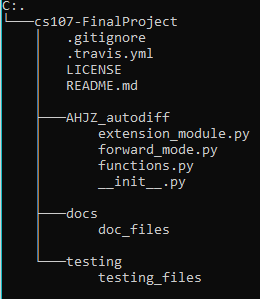

#### 2. __Modules:__
   * 2a. _functions.py_: This file contains sixteen methods to compute the function and derivative values of the elementary operations outlined below. These functions form the partial computational pieces required to perform automatic differentiation. The sixteen elementary functions are the following: '+', '-', '*' '/', 'sqrt(x)', 'power(x,n)', 'exp(x)', 'log(x, b)', 'ln(x)', 'sin(x)', 'cos(x)', 'tan(x)', 'cot(x)', 'csc(x)', 'sec(x)'.
    
   * 2b. _forward_mode.py_: This file computes the gradient using automatic differentiation forward mode. A user is required to input the function they are interested in computing the derivative of and the point or vector at which the derivative is to be evaluated at.
    
   * 2c. _fast_forward_mode.py_ (extension module): This file will contain our extension to the basic automatic differentiation functionality. In this module we compute the gradient using an efficient version of forward mode of automatic differentation by using an efficient graph data structure and optimized tree traversal. A user is required to input the function they are interested in computing the derivative of and the point or vector at which the derivative is to be evaluated at. 


#### 3. __Test Suite Location:__
   * 3a. The test suite will live in the "testing" directory which is a subdirectory found off the root directory (see 1. Directory Structure). The "testing" directory will contain all unit tests for our different modules. 
    
   * 3b. To ensure our testing procedure has complete code coverage, we will leverage CodeCov. CodeCov will enable us to quickly understand which lines are being executed in our test cases. Moreover, we will make use of TravisCI in order to see which of our unit tests are passing/failing. 
    
    
#### 4. __Package Distribution:__
   * 4a. The package will be distributed via PyPI. To deploy our package on PyPI and make it available for others to use, we would also need to add setup.py and setup.cfg files.


#### 5. __Packaging the Software:__
   * 5a. The software will be packaged using PyScaffold, which is a key builder for Python packages regarding data science. We plan on using this framework for packaging as it enables us to maintain and upgrade our package using templates and ready-to-use configurations to improve and further develop our program with newer versions of Python and external library dependencies. Moreover, we will use readthedocs to document, build, and host our documentation automatically. With readthedocs, if we were to upgrade the package to new versions, it would seemlessly update our documentation accordingly.
   
#### 6. __Other Considerations: Package Dependencies__
   * 6a. The only library dependency our package will rely on is numpy. We design our software this way to ensure that we are not creating multiple external dependencies and thereby increase our software's reliability .


# Implementation

_Discuss how you plan on implementing the forward mode of automatic differentiation._

#### 1.  __Core Data Structure:__
   * 1a. Our primary core data structure is going to be a dictionary to store each node in the computational graph that uses the tangent trace and primal trace to compute the partial differentiation and function value for a specific variable. More specifically, the keys would be the node of the computational graph (state name) and the values are going to be a tuple that holds the associated operation at the specific state (function value and derivative).  
      
      
#### 2.  __Classes:__
    
   * 2a. _Dual Numbers_: Class which represents the way in which operations are computed for a dual number    
    
   * 2b. _Forward Mode_: Class which represents the computational graph as a dictionary and performs forward mode differentiation  
     
   * 2c. _Fast Forward Mode_ (extension module): Class which represents an optimized data structure for how to store the compututional graph and performs a faster version of forward mode differentiation.
    
    
#### 3.  __Method and Name Attributes:__
   * 3a. _Dual Numbers_:
        * Method to initialize the real value and dual number value for the input of the function          
        * Methods to overload the elementary operations for a variable that is dual number
            * For example, we would use the below method to overload the "add" operation: 
            ```python  
               def __add__(self, other):
                        if isinstance(other, DualNumber):
                            return DualNumber(self.real + other.real, self.dual + other.dual)
            ```
   * 3b. _Forward Mode_:
        * Method to initialize the computational graph dictionary, its initial _x_ value, and an empty dictionary of the primal trace and tangent trace to perform forward mode automatic differentiation
        * Method to iterate through the input function and append to the primal and tangent trace dictionary
        * Method to get the node's value and partial derivative at the current step of forward mode
        * Method to obtain the primal trace to arrive at the next node's value and partial derivative
        * Method to obtain the tangent trace to arrive at the next node's value and partial derivative
        * Method to run the entire forward mode process and obtain the final function value and derivative from the computational graph.  
          
   * 3c. _Fast Forward Mode_:
        * Method to initialize the optimized computational graph data structure, its initial _x_ value, and an empty optimized structure of the primal and tangent trace to perform forward mode automatic differentiation
        * Method to iterate through the input function and append to the primal and tangent trace data structure
        * Method to get the node's value and partial derivative at the current step of forward mode
        * Method to obtain the primal trace to arrive at the next node's value and partial derivative
        * Method to obtain the tangent trace to arrive at the next node's value and partial derivative
        * Method to efficiently run the entire forward mode process and obtain the final function value and derivative from the optimized computational graph.
    
   
#### 4. __External Dependencies:__
   * 4a. The only external library we will rely on is numpy, which we will use to perform computations and evaluate small expressions with. With this being our only external dependency, our software increases its reliability and can be viewed as a near stand alone software package. 
    
    
#### 5.  __Dealing With Elementary Functions__
   * 5a. For all elementary functions like _sin_, _sqrt_, _log_, and _exp_ (and all the others mentioned in _Modules_) we will define separate methods for them in _functions.py_. This module will generalize each of the functions in order to handle both scalar and vector input. Each method will take in as an input a vector or scalar value stored at the previous node in the computational graph and output the derivative value and function value for that elementary function. We can then store the methods' outputs as a tuple in the computational graph dictionary alongside its primal and tangent traces. 
   
   * 5b. For example, we would use the below functions to implement _sin_ and _sqrt_, both of which work with scalar or vector input _x_ values: 
```python  
    # input x can be either a scalar or vector value
    def sin(x): 
        x_val = np.sin(x)
        x_der = np.cos(x)
        return (x_val, x_der)
```
```python  
    # input x can be either a scalar or vector value
    def sqrt(x): 
        x_val = np.sqrt(x)
        x_der = 0.5 * np.power(x, -0.5)
        return (x_val, x_der)
```


# Licensing

_Briefly motivate your license choice_

Our _AHJZ_autodiff_ package is licensed under the GNU General Public License v3.0. This free software license allows users to do just about anything they want with our project, except distribute closed source versions. This means that any improved versions of our package that individuals seek to release must also be free software. We find it essential to allow users to help each other share their bug fixes and improvements with other users. Our hope is that users of this package continually find ways to improve it and share these improvements within the broader scientific community that uses automatic differentation.